<center><h1> Taller ETI195: xAI </h1><center>




En el taller de esta semana estaremos trabajando el concepto de xAI (Inteligencia Artificial Explicable). En este contexto se presenta la librería LIME, que tiene por objetivo explicar las predicciones de cualquier modelo de clasificación aprendiendo un modelo inherentemente interpretable de forma local alrededor de una predicción.
Entender las razones detras de las predicciones es fundamental si se busca tomar decisiones basadas en el output del modelo, además de proveer información útil del modelo que podemos usar para transformar un modelo poco fiable en uno fiable.

Es importante que diferenciemos entre dos conceptos relacionados a la confianza del usuario en el modelo:

- **Confianza del usuario en una predicción**, que se relaciona con si un usuario confía lo suficiente en una predicción del modelo como para tomar una decisión en base a esta. En este caso la interpretabilidad local ofrecida por LIME permite evaluar cuál es el aporte de cada feature en un output del modelo, favoreciendo así la posición del usuario para poder tomar decisiones.

- **Confianza del usuario en el modelo**, que se relaciona con si el usuario confía en que el modelo funcionará de manera razonable cuando se ponga en funcionamiento. Además de mirar y comparar métricas de rendimiento a la hora de seleccionar modelos, también es importante medir qué tan confiable es el modelo. LIME ofrece la posibilidad de, a través de las explicaciones individuales, seleccionar algunas explicaciones locales para entregarle al usuario una visión general del funcionamiento del modelo.

LIME es un algoritmo que puede explicar las predicciones de cualquier clasificador de manera fiel, aproximando dicho clasificador de manera local con un modelo interpretable. Con explicar una predicción, nos referimos a presentar texto o artefactos visuales que permitan entender la relación entre las componentes de la instancia (por ejemplo, palabras en un texto) y la predicción del modelo.

Por ejemplo, suponga que un doctor utiliza un modelo para la predicción de enfermedades en base a sus síntomas. Es claro que el doctor está en mejor posición para tomar decisiones con la ayuda del modelo si es que este tiene explicaciones entendibles. Los humanos, por lo general, tienen conocimiento del dominio de aplicación, el que pueden utilizar para aceptar o rechazar la predicción si entienden el razonamiento detrás de esta.

![Ejemplo](https://i.ibb.co/CwzK1vm/Captura-de-pantalla-de-2024-05-28-14-25-51.png)

Mirar a explicaciones de la predicción para ciertas instancias puede ayudar a evaluar la confianza en el modelo. Considere el ejemplo de un modelo de texto que clasifica noticias entre cristianas o ateas, y la explicación para la predicción de la misma instancia hecha por modelos distintos:

![Ejemplo](https://i.ibb.co/5YG7pyx/Captura-de-pantalla-de-2024-05-28-14-31-10.png)

A pesar de que el modelo de la derecha tiene más accuracy, es claro que este último es peor que el modelo de la izquierda.

### ¿Cómo funciona LIME?

Como su nombre lo indica, LIME se basa en interpretabilidad a una escala local. En el taller pasado vimos el concepto de modelo sustituto, donde aprendíamos un modelo inherentemente explicable (por ejemplo un árbol de decisión) sobre un modelo más complejo, en búsqueda de explicabilidad global. LIME, en cambio, se enfoca en aprender modelos sustitutos en forma local (en una vecindad de la instancia).

![Explicabiilidad Local](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)

Podemos resumir el funcionamiento de LIME en los siguientes pasos:

1. Obtener una muestra de datos sintéticos alrededor de la instancia de interés.
2. Obtener las predicciones del modelo para estos puntos.
3. Entrenar un modelo interpretable con los datos perturbados, asignando pesos a los datos según la cercanía a la instancia de interés (más cerca, más peso tienen en el entrenamiento).
4. Explicar la predicción interpretando el modelo local.

In [78]:
# Instalar la librería LIME
%pip install lime

Note: you may need to restart the kernel to use updated packages.


In [79]:
# Utilizaremos datos provenientes de AIF360
%pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [80]:
# Importación de librerías

# elementales

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.datasets import load_breast_cancer


# Para obtener los datos de aif360

from aif360.sklearn.datasets import fetch_german

## Obtención y manipulación de los datos

Estaremos utilizando nuevamente el dataset 'German Credit Data'.

In [81]:
# Obtenemos los datos.

X, y = fetch_german()
X.head()

checking_status  duration  \
sex    age   foreign_worker                             
male   aged  yes                         <0         6   
female young yes                   0<=X<200        48   
male   aged  yes                no checking        12   
             yes                         <0        42   
             yes                         <0        24   

                                             credit_history  \
sex    age   foreign_worker                                   
male   aged  yes             critical/other existing credit   
female young yes                              existing paid   
male   aged  yes             critical/other existing credit   
             yes                              existing paid   
             yes                         delayed previously   

                                         purpose  credit_amount  \
sex    age   foreign_worker                                       
male   aged  yes                        radio/tv           1169   
female young yes                        radio/tv           5951   
male   aged  yes                       education           2096   
             yes             furniture/equipment           7882   
             yes                         new car           4870   

                               savings_status employment  \
sex    age   foreign_worker                                
male   aged  yes             no known savings        >=7   
female young yes                         <100     1<=X<4   
male   aged  yes                         <100     4<=X<7   
             yes                         <100     4<=X<7   
             yes                         <100     1<=X<4   

                             installment_commitment other_parties  \
sex    age   foreign_worker                                         
male   aged  yes                                  4          none   
female young yes                                  2          none   
male   aged  yes                                  2          none   
             yes                                  2     guarantor   
             yes                                  3          none   

                             residence_since  ... age  other_payment_plans  \
sex    age   foreign_worker                   ...                            
male   aged  yes                           4  ...  67                 none   
female young yes                           2  ...  22                 none   
male   aged  yes                           3  ...  49                 none   
             yes                           4  ...  45                 none   
             yes                           4  ...  53                 none   

                              housing existing_credits                 job  \
sex    age   foreign_worker                                                  
male   aged  yes                  own                2             skilled   
female young yes                  own                1             skilled   
male   aged  yes                  own                1  unskilled resident   
             yes             for free                1             skilled   
             yes             for free                2             skilled   

                            num_dependents  own_telephone foreign_worker  \
sex    age   foreign_worker                                                
male   aged  yes                         1            yes            yes   
female young yes                         1           none            yes   
male   aged  yes                         2           none            yes   
             yes                         2           none            yes   
             yes                         2           none            yes   

                                sex marital_status  
sex    age   foreign_worker                         
male   aged  yes               male         single  
female young yes         

In [82]:
# Los manipularemos para dejarlos en el formato habitual.

df = (
    pd.concat([X, y], axis=1)
    .drop(columns=["sex", "foreign_worker"])
    .rename(columns={"age": "age_numeric"})
    .reset_index()
)
df.head()

,sex,age,foreign_worker,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,...,property_magnitude,age_numeric,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,marital_status,credit-risk
0,male,aged,yes,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,...,real estate,67,none,own,2,skilled,1,yes,single,good
1,female,young,yes,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,...,real estate,22,none,own,1,skilled,1,none,div/dep/mar,bad
2,male,aged,yes,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,...,real estate,49,none,own,1,unskilled resident,2,none,single,good
3,male,aged,yes,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,...,life insurance,45,none,for free,1,skilled,2,none,single,good
4,male,aged,yes,<0,24,delayed previously,new car,4870,<100,1<=X<4,...,no known property,53,none,for free,2,skilled,2,none,single,bad


In [83]:
df = df.rename(columns={"age": "age_cat", "age_numeric": "age"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   sex                     1000 non-null   category
 1   age_cat                 1000 non-null   category
 2   foreign_worker          1000 non-null   category
 3   checking_status         1000 non-null   category
 4   duration                1000 non-null   int64   
 5   credit_history          1000 non-null   category
 6   purpose                 1000 non-null   category
 7   credit_amount           1000 non-null   int64   
 8   savings_status          1000 non-null   category
 9   employment              1000 non-null   category
 10  installment_commitment  1000 non-null   int64   
 11  other_parties           1000 non-null   category
 12  residence_since         1000 non-null   int64   
 13  property_magnitude      1000 non-null   category
 14  age                     1

### Descripción de las columnas.

**Atributos Numéricos**

- `duration`: Duración en meses. Rango (4,72).
- `credit_amount`: Cantidad de crédito solicitada. Rango (250, 18424) en DM - Marco alemán.
- `installment_commitment`: Tasa de cuota en porcentaje del ingreso disponible. Rango (1,4).
- `residence_since`: Tiempo de residencia actual. Rango (1,4).
- `age`: Edad en años. Rango (19, 75).
- `existing_credits`: Número de créditos existentes en este banco. Rango (1,4) en DM - Marco alemán.
- `num_dependents`: Número de personas responsables de proveer el mantenimiento. Rango (1,2).

**Atributos Categóricos**

- `checking_status`: Valores `'0<=X<200', '<0', '>=200', 'no checking'`.
- `credit_history`: Historial crediticio del solicitante. Valores `['all paid', 'critical/other existing credit', 'delayed previously', 'existing paid', 'no credits/all paid']`.
- `purpose`: Motivo por el cual el solicitante solicitó un préstamo. Valores `['business', 'domestic appliance', 'education', 'furniture/equipment', 'new car', 'other', 'radio/tv', 'repairs', 'retraining', 'used car']`.
- `savings_status`: Cuenta de ahorros/bonos. Valores `['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings']`.
- `employment`: Empleo actual desde (en años). Valores `['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed']`.
- `other_parties`: Otros deudores / garantes. Valores `['co applicant', 'guarantor', 'none']`.
- `property_magnitude`: Bienes del solicitante. Valores `['car', 'life insurance', 'no known property', 'real estate']`.
- `other_payment_plans`: Otros planes de pago a plazos. Valores `['bank', 'none', 'stores']`.
- `housing`: Situación de vivienda del solicitante. Valores `['for free', 'own', 'rent']`.
- `job`: Categorías de empleo definidas por el banco. Valores `['high qualif/self emp/mgmt', 'skilled', 'unemp/unskilled non res', 'unskilled resident']`.
- `own_telephone`: Si hay un teléfono registrado a nombre del cliente. Valores `['none', 'yes']`.
- `foreign_worker`: **Atributo protegido**. Valores `['no', 'yes']`.
- `sex`: **Atributo protegido**. Valores `['female', 'male']`.
- `marital_status`: Estado civil. Valores `['div/dep/mar', 'div/sep', 'mar/wid', 'single']`.

**Etiqueta**

- `credit-risk`: `'good'` (favorable) o `'bad'` (desfavorable).

## Pre-procesamiento

Haremos el pre-procesamiento de nuestros datos para poder trabajar con los algoritmos.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   sex                     1000 non-null   category
 1   age_cat                 1000 non-null   category
 2   foreign_worker          1000 non-null   category
 3   checking_status         1000 non-null   category
 4   duration                1000 non-null   int64   
 5   credit_history          1000 non-null   category
 6   purpose                 1000 non-null   category
 7   credit_amount           1000 non-null   int64   
 8   savings_status          1000 non-null   category
 9   employment              1000 non-null   category
 10  installment_commitment  1000 non-null   int64   
 11  other_parties           1000 non-null   category
 12  residence_since         1000 non-null   int64   
 13  property_magnitude      1000 non-null   category
 14  age                     1

In [85]:
# Binarización de algunas variables.

df["sex"] = df["sex"].map({"male": 1, "female": 0})
df["age_cat"] = df["age_cat"].map({"aged": 1, "young": 0})
df["foreign_worker"] = df["foreign_worker"].map({"no": 1, "yes": 0})
df["credit-risk"] = df["credit-risk"].map({"good": 1, "bad": 0})

In [86]:
# Separamos X e Y.

X = df.loc[:, df.columns != "credit-risk"].copy()
y = df.loc[:, df.columns == "credit-risk"].copy()

In [87]:
# Necesitamos ocupar Label Encoder
to_encode = X.select_dtypes(include="category")
encoders = {}
for catcol in to_encode.columns:
    encoder = LabelEncoder()
    X[catcol] = encoder.fit_transform(X[catcol])
    encoders[catcol] = encoder

X.head()

,sex,age_cat,foreign_worker,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,marital_status
0,1,1,0,1,6,1,6,1169,4,3,...,4,3,67,1,1,2,1,1,1,3
1,0,0,0,0,48,3,6,5951,2,0,...,2,3,22,1,1,1,1,1,0,0
2,1,1,0,3,12,1,2,2096,2,1,...,3,3,49,1,1,1,3,2,0,3
3,1,1,0,1,42,3,3,7882,2,1,...,4,1,45,1,0,1,1,2,0,3
4,1,1,0,1,24,2,4,4870,2,0,...,4,2,53,1,0,2,1,2,0,3


In [88]:
# Datos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=908
)

In [89]:
# No utilizaremos la edad

X_train.drop(columns=["age"], inplace=True)
X_test.drop(columns=["age"], inplace=True)

In [90]:
rf = RandomForestClassifier(random_state=405)
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(random_state=405)

In [91]:
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred)

np.float64(0.8258064516129032)

In [92]:
categorical_features = to_encode.columns.tolist()

categorical_names = {col: encoders[col].classes_ for col in categorical_features}

In [93]:
categorical_features

['sex',
 'age_cat',
 'foreign_worker',
 'checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'marital_status']

In [94]:
categorical_names

{'sex': array([0, 1]),
 'age_cat': array([0, 1]),
 'foreign_worker': array([0, 1]),
 'checking_status': array(['0<=X<200', '<0', '>=200', 'no checking'], dtype=object),
 'credit_history': array(['all paid', 'critical/other existing credit', 'delayed previously',
        'existing paid', 'no credits/all paid'], dtype=object),
 'purpose': array(['business', 'domestic appliance', 'education',
        'furniture/equipment', 'new car', 'other', 'radio/tv', 'repairs',
        'retraining', 'used car'], dtype=object),
 'savings_status': array(['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings'],
       dtype=object),
 'employment': array(['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed'], dtype=object),
 'other_parties': array(['co applicant', 'guarantor', 'none'], dtype=object),
 'property_magnitude': array(['car', 'life insurance', 'no known property', 'real estate'],
       dtype=object),
 'other_payment_plans': array(['bank', 'none', 'stores'], dtype=object),
 'housing': array

In [95]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="classification",
    feature_names=X_train.columns.tolist(),
    categorical_features=categorical_features, 
    categorical_names=categorical_names, 
    discretize_continuous=True,
    discretizer="decile",
    kernel_width=5,
)

In [96]:
instance_index = 6
instance_to_explain = X_train.iloc[[instance_index]]
exp = explainer.explain_instance(
    instance_to_explain.values[0],
    lambda x: rf.predict_proba(pd.DataFrame(x, columns=X_train.columns)),
    num_features=5,
)

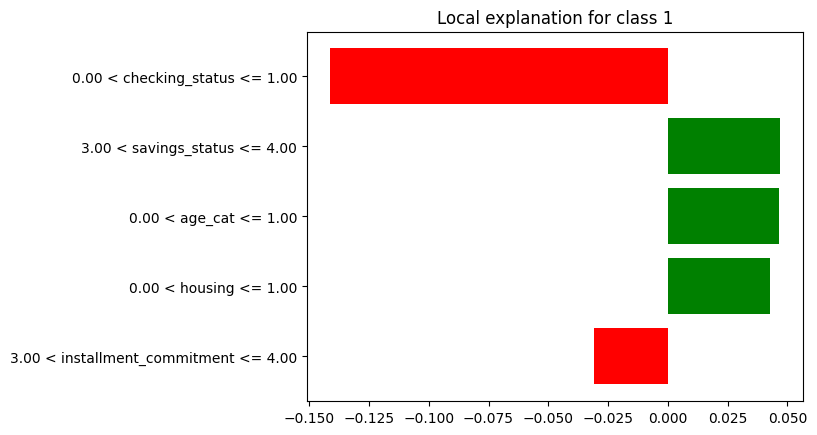

In [97]:
exp.as_pyplot_figure()
plt.show()

In [98]:
exp.show_in_notebook(show_all=False)

In [99]:
pd.DataFrame(exp.as_list(), columns=["Feature", "Contribution"])

,Feature,Contribution
0,0.00 < checking_status <= 1.00,-0.141511
1,3.00 < savings_status <= 4.00,0.047111
2,0.00 < age_cat <= 1.00,0.046640
3,0.00 < housing <= 1.00,0.042786
4,3.00 < installment_commitment <= 4.00,-0.031058


La librería SHAP fue propuesta para abordar este problema, asociando a cada feature un valor de importancia para una predicción en particular. Se proponen los SHAP values de la teoría de juegos como una medición unificada de la importancia de un feature en una predicción. Estas importancias además son aditivas.

Pueden encontrar más detalles en [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874) como también en el [repositorio de la librería.](https://github.com/shap)

In [100]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [101]:
import shap

In [102]:
X_train.head()

,sex,age_cat,foreign_worker,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,...,other_parties,residence_since,property_magnitude,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,marital_status
589,1,1,0,1,12,1,3,2246,2,3,...,2,3,1,1,1,2,1,1,0,3
336,0,0,0,0,13,3,6,2101,2,2,...,1,4,1,1,1,1,3,1,0,0
446,0,1,0,1,36,3,4,1842,2,2,...,2,4,0,1,1,1,1,1,1,0
997,1,1,0,3,12,3,6,804,2,3,...,2,4,0,1,1,1,1,1,0,3
917,1,1,0,1,6,3,4,14896,2,3,...,2,4,2,0,1,1,0,1,1,3


In [103]:
# Y entrenamos un modelo de Random Forest
rf

RandomForestClassifier(random_state=405)

In [104]:
# Instanciamos un explainer y obtenemos los shap values
explainer = shap.Explainer(rf.predict_proba, X_train)
shap_values = explainer(X_train[:100])

PermutationExplainer explainer: 101it [00:26,  1.94it/s]                         


In [105]:
# Nos quedamos con los shap values para la clase positiva.
shap_values = shap_values[..., 1]

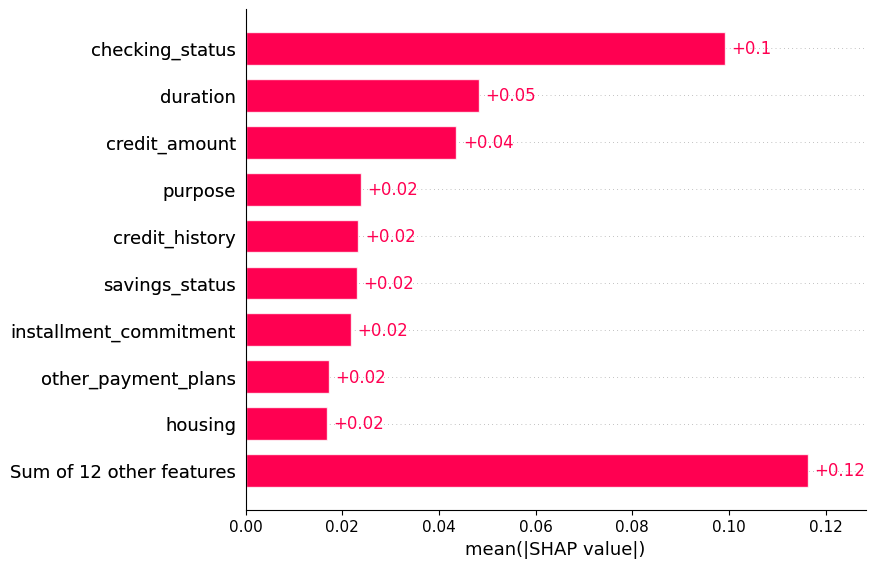

In [106]:
# Gráfico de barras
shap.plots.bar(shap_values)

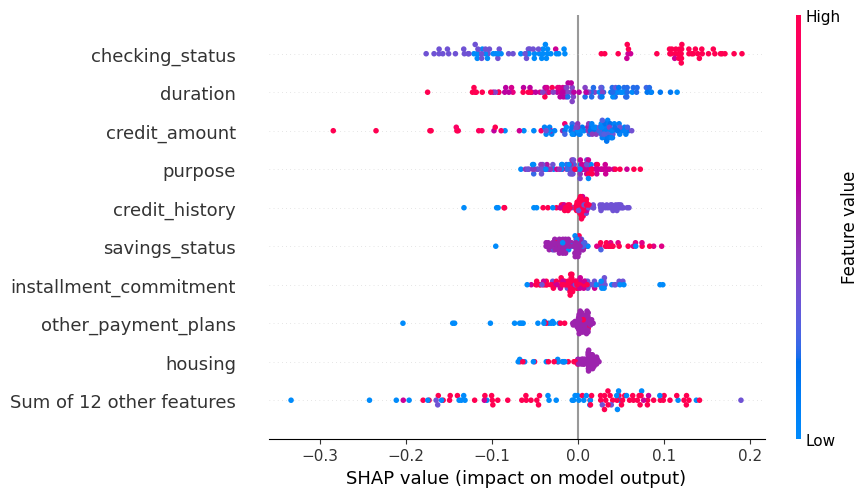

In [107]:
shap.plots.beeswarm(shap_values)

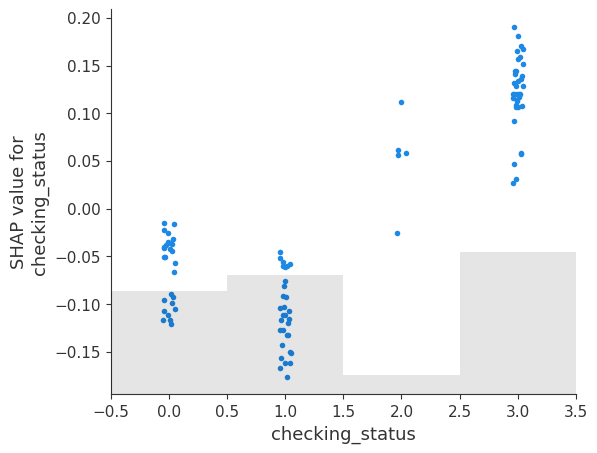

In [108]:
shap.plots.scatter(shap_values[:, "checking_status"])

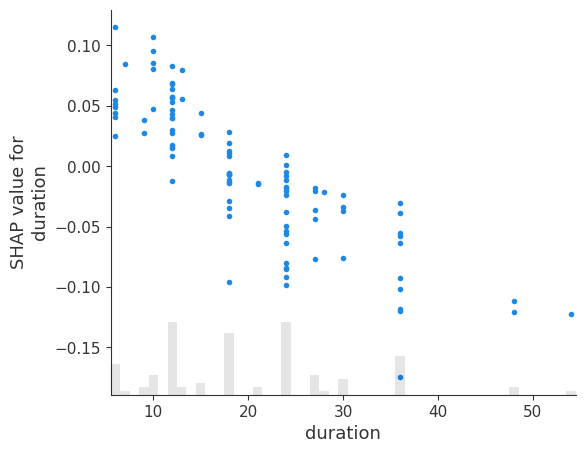

In [109]:
shap.plots.scatter(shap_values[:, "duration"])

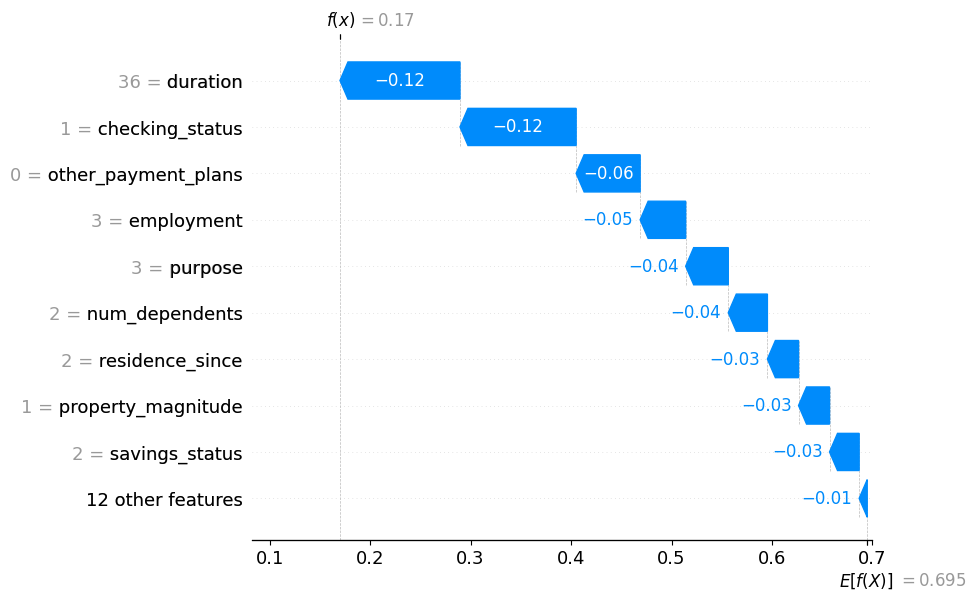

In [110]:
shap.plots.waterfall(shap_values[99])